# Imports

In [1]:
import numpy as np #for handling arrays 
import pandas as pd #for handling dataframes 
# for building models 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
# for hyperparameter tuning 
from sklearn.model_selection import train_test_split, GridSearchCV
# for model evaluation 
from sklearn.metrics import mean_absolute_error, r2_score
# for visualzing results 
import matplotlib.pyplot as plt 
# to interact with hardware and save the final model 
import os
import joblib
# to read data from SQL
import mysql.connector
# use the style available in seaborn library 
plt.style.use('seaborn')

# Constants 

In [2]:
# create some constants 
RESULTS_SAVE_PATH = 'Results/'
MODEL_SAVE_PATH = 'Objects/Models/'
EVALUATION_FIGSIZE = (16,6)
EVALUATION_NROWS = 1
EVALUATION_NCOLS = 2
CITIES = ['AHEMDABAD','BANGALORE','CHENNAI','DELHI','HYDERABAD','KOLKATA','MUMBAI','PUNE']
TEST_SIZE = 0.3
RANDOM_STATE = 42
with open('credentials.txt', 'r') as f:
    PASSWORD = f.read()

# Reading data

In [3]:
conn = mysql.connector.connect(
    host='34.93.147.30',
    port=3306,
    user='root',
    password=PASSWORD,
    database='PREPROCESS',
    auth_plugin='mysql_native_password'
)

df_dict = dict(zip(CITIES, [pd.read_sql(f'SELECT * FROM {city}', con=conn) for city in CITIES]))
conn.close()
cols = cols = ['SELLER TYPE','BEDROOM','LAYOUT TYPE','PROPERTY TYPE','LOCALITY','PRICE','AREA','FURNISH TYPE','BATHROOM']
for city, df in df_dict.items():
    df.columns = cols

# Preparing data for model

In [4]:
# store X and y for each city in dictionary
X_dict = dict(zip(CITIES,[df.drop(['PRICE'],axis=1) for df in df_dict.values()]))
y_dict = dict(zip(CITIES,[df['PRICE'] for df in df_dict.values()]))

In [5]:
# Create dictionaries for X_train, y_train, X_test and y_test 
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for city in CITIES:
    X = X_dict[city]
    y = y_dict[city]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=TEST_SIZE, random_state=RANDOM_STATE)
    X_train_dict[city] = X_train
    X_test_dict[city] = X_test
    y_train_dict[city] = y_train
    y_test_dict[city] = y_test

In [6]:
# create a helper function
def summarize_model(model,model_name):
    model_r2_train_dict = {} #create a dictionary for r2 score of train set
    model_r2_test_dict = {} #create a dictionary for r2 score of test set
    model_mae_train_dict = {} #create a dictionary for mae of train set 
    model_mae_test_dict = {} #create a dictionary for mae of test set
    model_dict = {} #create a dictionary of models 
    for city in CITIES: #loop through the cities 
        model.fit(X_train_dict[city],y_train_dict[city]) #fit the model 
        model_dict[city] = model #store the model for that city in model dict
        model_train_preds = model.predict(X_train_dict[city]) #predict for train set 
        model_test_preds = model.predict(X_test_dict[city]) #predict for test set 
        model_r2_train_dict[city] = r2_score(y_true=y_train_dict[city], y_pred=model_train_preds) #calculate r2 for train set 
        model_r2_test_dict[city] = r2_score(y_true=y_test_dict[city], y_pred=model_test_preds) #calculate r2 for test set 
        model_mae_train_dict[city] = mean_absolute_error(y_true=y_train_dict[city],y_pred=model_train_preds) #calcaulte mae for train set
        model_mae_test_dict[city] = mean_absolute_error(y_true=y_test_dict[city], y_pred=model_test_preds) #calculate mae for test set 
        # print the results 
        print(f'The r2 score on train set for {model_name} for {city} is {model_r2_train_dict[city]}')
        print(f'The r2 score on test set for {model_name} for {city} is {model_r2_test_dict[city]}')
        print(f'The MAE on train set for {model_name} for {city} is {model_mae_train_dict[city]}')
        print(f'The MAE on test set for {model_name} for {city} is {model_mae_test_dict[city]}')
        print('\n')
    # store the metrics in a dictionary 
    metrics_dict = {
        'train r2':model_r2_train_dict,
        'test r2':model_r2_test_dict,
        'train mae':model_mae_train_dict,
        'test mae':model_mae_test_dict
    }
    return model_dict, metrics_dict #return model and metrics 

In [7]:
# Linear Regression 
lr_dict, lr_metrics = summarize_model(LinearRegression(),model_name='Linear Regression')

The r2 score on train set for Linear Regression for AHEMDABAD is 0.576700970473565
The r2 score on test set for Linear Regression for AHEMDABAD is 0.5723428032505314
The MAE on train set for Linear Regression for AHEMDABAD is 4227.8793610655075
The MAE on test set for Linear Regression for AHEMDABAD is 4337.0962842342105


The r2 score on train set for Linear Regression for BANGALORE is 0.6376625267949352
The r2 score on test set for Linear Regression for BANGALORE is 0.6511843536433515
The MAE on train set for Linear Regression for BANGALORE is 3941.2293488041487
The MAE on test set for Linear Regression for BANGALORE is 3904.564388077985


The r2 score on train set for Linear Regression for CHENNAI is 0.6333233838219874
The r2 score on test set for Linear Regression for CHENNAI is 0.6365410443645032
The MAE on train set for Linear Regression for CHENNAI is 4117.093986433704
The MAE on test set for Linear Regression for CHENNAI is 4119.248055736776


The r2 score on train set for Line

In [8]:
# Decision tree regression 
dt_dict, dt_metrics = summarize_model(DecisionTreeRegressor(),model_name='Decision Tree Regressor')

The r2 score on train set for Decision Tree Regressor for AHEMDABAD is 0.9700017868310461
The r2 score on test set for Decision Tree Regressor for AHEMDABAD is 0.5196618294653244
The MAE on train set for Decision Tree Regressor for AHEMDABAD is 592.4605131904386
The MAE on test set for Decision Tree Regressor for AHEMDABAD is 4073.208496687194


The r2 score on train set for Decision Tree Regressor for BANGALORE is 0.9757964574423078
The r2 score on test set for Decision Tree Regressor for BANGALORE is 0.5118580241678802
The MAE on train set for Decision Tree Regressor for BANGALORE is 486.06601397638497
The MAE on test set for Decision Tree Regressor for BANGALORE is 4320.759660046509


The r2 score on train set for Decision Tree Regressor for CHENNAI is 0.9914410080964173
The r2 score on test set for Decision Tree Regressor for CHENNAI is 0.4460384823176622
The MAE on train set for Decision Tree Regressor for CHENNAI is 221.40105899312488
The MAE on test set for Decision Tree Regress

In [9]:
# Random forest regression  
rf_dict, rf_metrics = summarize_model(RandomForestRegressor(),model_name='Random Forest Regression')

The r2 score on train set for Random Forest Regression for AHEMDABAD is 0.937652459033271
The r2 score on test set for Random Forest Regression for AHEMDABAD is 0.7080023437522889
The MAE on train set for Random Forest Regression for AHEMDABAD is 1473.3013389227722
The MAE on test set for Random Forest Regression for AHEMDABAD is 3304.210913979545


The r2 score on train set for Random Forest Regression for BANGALORE is 0.9391793334523193
The r2 score on test set for Random Forest Regression for BANGALORE is 0.7136820331507829
The MAE on train set for Random Forest Regression for BANGALORE is 1526.191590552281
The MAE on test set for Random Forest Regression for BANGALORE is 3453.3598971388806


The r2 score on train set for Random Forest Regression for CHENNAI is 0.9509801355015389
The r2 score on test set for Random Forest Regression for CHENNAI is 0.6745675148794139
The MAE on train set for Random Forest Regression for CHENNAI is 1405.0476439463453
The MAE on test set for Random For

In [10]:
# Adaboost Regression
adaboost_dict, adaboost_metrics = summarize_model(AdaBoostRegressor(), model_name='Adaboost Regression')

The r2 score on train set for Adaboost Regression for AHEMDABAD is 0.4458671819164036
The r2 score on test set for Adaboost Regression for AHEMDABAD is 0.43331869116597443
The MAE on train set for Adaboost Regression for AHEMDABAD is 5347.801618012765
The MAE on test set for Adaboost Regression for AHEMDABAD is 5465.15784159507


The r2 score on train set for Adaboost Regression for BANGALORE is 0.5826315436265412
The r2 score on test set for Adaboost Regression for BANGALORE is 0.5888843222293153
The MAE on train set for Adaboost Regression for BANGALORE is 4497.2344265560805
The MAE on test set for Adaboost Regression for BANGALORE is 4450.645758169827


The r2 score on train set for Adaboost Regression for CHENNAI is 0.5998415289054829
The r2 score on test set for Adaboost Regression for CHENNAI is 0.5938167201511392
The MAE on train set for Adaboost Regression for CHENNAI is 4631.570633068534
The MAE on test set for Adaboost Regression for CHENNAI is 4667.135949135644


The r2 scor

In [11]:
# Gradient boosting regression 
gb_dict, gb_metrics = summarize_model(GradientBoostingRegressor(), model_name='Gradient Boosting Regression')

The r2 score on train set for Gradient Boosting Regression for AHEMDABAD is 0.754845711558321
The r2 score on test set for Gradient Boosting Regression for AHEMDABAD is 0.7269772224664948
The MAE on train set for Gradient Boosting Regression for AHEMDABAD is 3106.9554756641887
The MAE on test set for Gradient Boosting Regression for AHEMDABAD is 3292.1783776295597


The r2 score on train set for Gradient Boosting Regression for BANGALORE is 0.727093412141096
The r2 score on test set for Gradient Boosting Regression for BANGALORE is 0.725919418530599
The MAE on train set for Gradient Boosting Regression for BANGALORE is 3400.725404741338
The MAE on test set for Gradient Boosting Regression for BANGALORE is 3437.5127839246934


The r2 score on train set for Gradient Boosting Regression for CHENNAI is 0.7562348726292764
The r2 score on test set for Gradient Boosting Regression for CHENNAI is 0.7190232964312029
The MAE on train set for Gradient Boosting Regression for CHENNAI is 3249.53709

In [12]:
# XGBoost Regression 
xgb_dict, xgb_metrics = summarize_model(XGBRegressor(objective='reg:squarederror'), model_name='XG Boost Regression')

The r2 score on train set for XG Boost Regression for AHEMDABAD is 0.898985283084349
The r2 score on test set for XG Boost Regression for AHEMDABAD is 0.7408532557998565
The MAE on train set for XG Boost Regression for AHEMDABAD is 1968.2262611197236
The MAE on test set for XG Boost Regression for AHEMDABAD is 3076.722131748826


The r2 score on train set for XG Boost Regression for BANGALORE is 0.8706436710478038
The r2 score on test set for XG Boost Regression for BANGALORE is 0.761719681748888
The MAE on train set for XG Boost Regression for BANGALORE is 2296.8065463664725
The MAE on test set for XG Boost Regression for BANGALORE is 3127.1685506174426


The r2 score on train set for XG Boost Regression for CHENNAI is 0.9332182412016006
The r2 score on test set for XG Boost Regression for CHENNAI is 0.7328557329833739
The MAE on train set for XG Boost Regression for CHENNAI is 1693.9631647349831
The MAE on test set for XG Boost Regression for CHENNAI is 3206.0458281352257


The r2 sc

In [13]:
# create dictionaries for visualization 
model_dict = {
    'LR':lr_dict,
    'DT':dt_dict,
    'RF':rf_dict,
    'ADA':adaboost_dict,
    'GB':gb_dict,
    'XGB':xgb_dict
}
model_metrics = {
    'LR':lr_metrics,
    'DT':dt_metrics,
    'RF':rf_metrics,
    'ADA':adaboost_metrics,
    'GB':gb_metrics,
    'XGB':xgb_metrics
}


In [14]:
# Create dictionaries for metrics for all models 
train_r2 = {}
test_r2 = {}
train_mae = {}
test_mae = {}

for model, metrics_dict in model_metrics.items():
    train_r2[model] = metrics_dict['train r2']
    test_r2[model] = metrics_dict['test r2']
    train_mae[model] = metrics_dict['train mae']
    test_mae[model] = metrics_dict['test mae']

In [15]:
# Convert them to dataframes 
train_r2 = pd.DataFrame(train_r2)
test_r2 = pd.DataFrame(test_r2)
train_mae = pd.DataFrame(train_mae)
test_mae = pd.DataFrame(test_mae)

In [16]:
# Change the column names for identification 
train_r2.columns = [col+'_train_r2' for col in train_r2.columns]
test_r2.columns = [col+'_test_r2' for col in test_r2.columns] 
train_mae.columns = [col+'_train_mae' for col in train_mae.columns]
test_mae.columns = [col+'_test_mae' for col in test_mae.columns]

In [17]:
# Create dataframe for plotting r2 score 
plot_r2 = pd.DataFrame()
for c1, c2 in zip(train_r2.columns, test_r2.columns):
    plot_r2[c1] = train_r2[c1]
    plot_r2[c2] = test_r2[c2]

In [18]:
# create dataframe for plotting mae 
plot_mae = pd.DataFrame()
for c1,c2 in zip(train_mae.columns, test_mae.columns):
    plot_mae[c1] = train_mae[c1]
    plot_mae[c2] = test_mae[c2]

In [19]:
# transpose the dataframes for easy plotting 
plot_r2 = plot_r2.T
plot_mae = plot_mae.T

In [20]:
# Reshape cities to plot better 
cities_plot = np.array(CITIES).reshape(4,2)

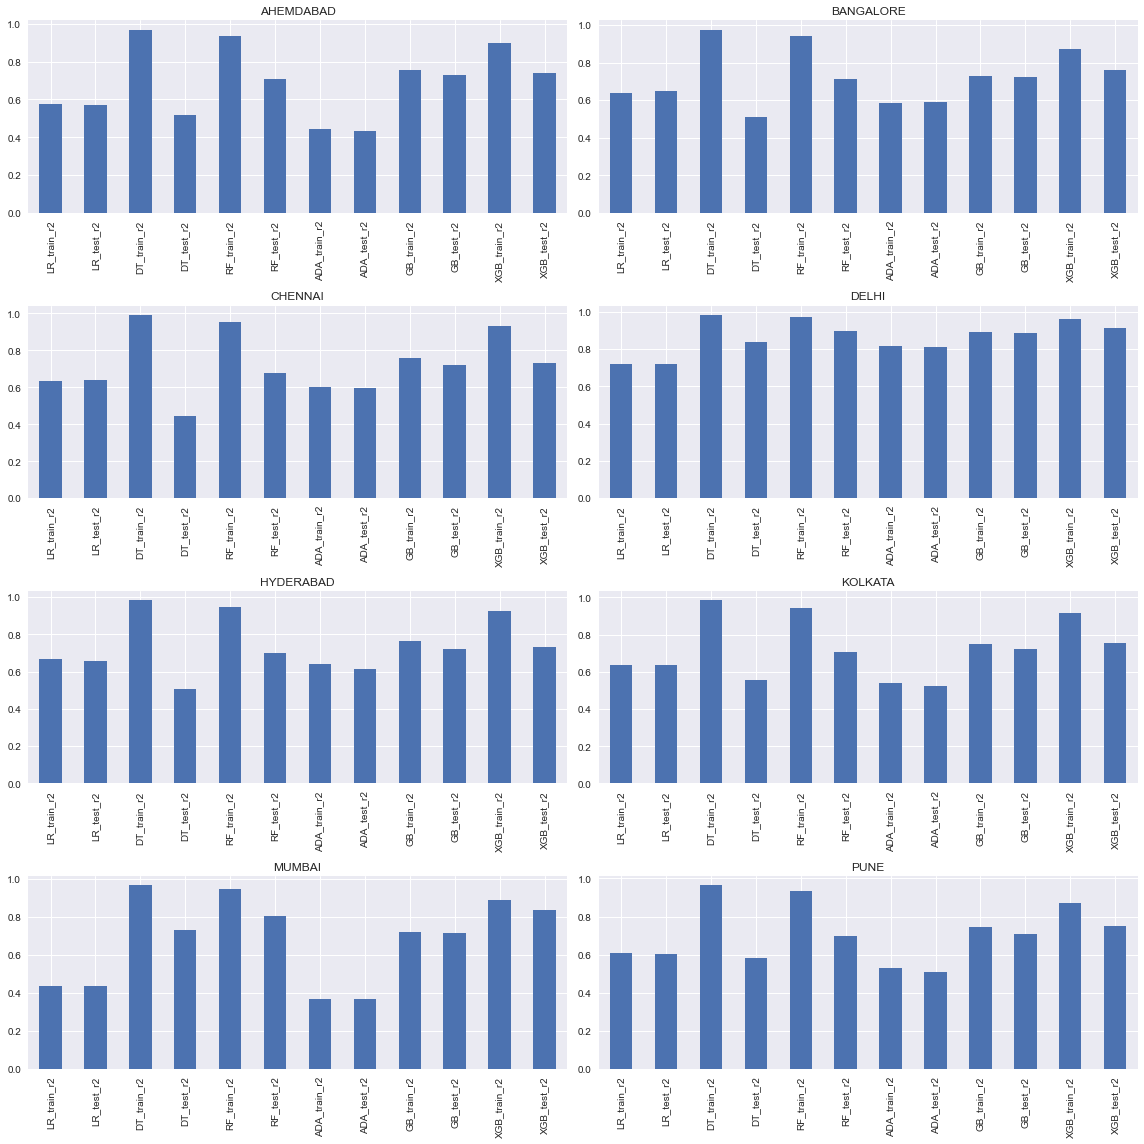

In [21]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2) #create a 4*2 figure 
for i in range(4): #loop through rows 
    for j in range(2): #loop through columns 
        plot_r2[cities_plot[i,j]].plot(kind='bar',ax=ax[i,j]) #plot the column  
        ax[i,j].set_title(cities_plot[i,j]) #set title 
plt.tight_layout() #tight layout for avoiding overlap 
if not os.path.exists(RESULTS_SAVE_PATH): #check if path exists 
    os.makedirs(RESULTS_SAVE_PATH) #if not, create the path 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'all_models_r2.png')) #save the results 
plt.show() #show the plot 

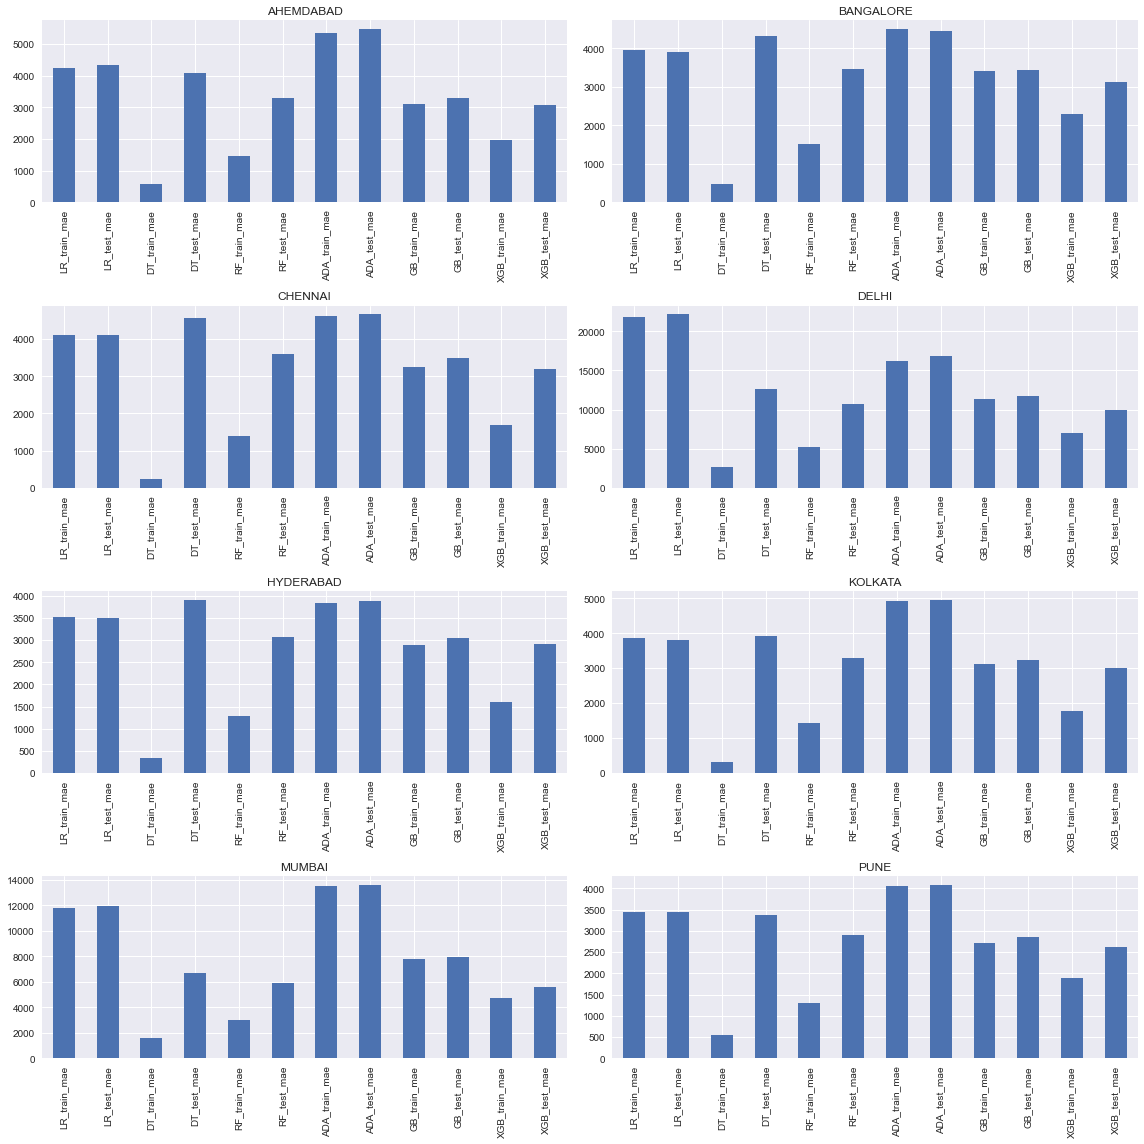

In [22]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2) #create 4*2 figure 
for i in range(4): #loop through rows 
    for j in range(2): #loop through columns 
        plot_mae[cities_plot[i,j]].plot(kind='bar',ax=ax[i,j]) #plot the column 
        ax[i,j].set_title(cities_plot[i,j]) #set the title 
plt.tight_layout() #tight layout to avoud overlap 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'all_moedls_mae.png')) #save the figure 
plt.show() #show the figure 

From the above graphs, we can say that XGBRegressor() has the highest r2 score for all the cities and the lowest MAE, hence we will validate the XGBRegressor() model for GridSearchCV()

In [23]:
# hyperparameter tuning 
param_tuning = {
        'learning_rate': [0.001,0.01,0.1],
        'max_depth': [3, 5, 7, 10],
        'n_estimators' : [100, 200,300,400, 500],
    }

In [24]:
# perform cross validation
xgb_validated_dict = {} #create a dictionary for validated xgboost model 
for city, model in xgb_dict.items(): #loop though  existing xgboost model 
    xgb_validated = GridSearchCV(model, param_tuning, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error') #perform cross validation
    xgb_validated.fit(X_train_dict[city], y_train_dict[city]) #fit the validated model 
    xgb_validated_dict[city] = xgb_validated #save the model in the dictionary 

Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting 3 folds for each of 60 candidates, totalling 180 fits


In [25]:
# create a dictionary for metrics 
xgb_validated_metrics = {}
train_r2_dict = {}
test_r2_dict = {}
train_mae_dict = {}
test_mae_dict = {}
for city, model in xgb_validated_dict.items(): #loop through validated xgboost models 
    train_preds = model.predict(X_train_dict[city]) #predict on train set 
    test_preds = model.predict(X_test_dict[city]) #predict on test set 
    train_r2 = r2_score(y_true=y_train_dict[city],y_pred=train_preds) #calculate r2 on train set 
    test_r2 = r2_score(y_true=y_test_dict[city],y_pred=test_preds) #calculate r2 on test set 
    train_mae = mean_absolute_error(y_true=y_train_dict[city], y_pred=train_preds) #calculate mae on train set 
    test_mae = mean_absolute_error(y_true=y_test_dict[city],y_pred=test_preds) #calculate mae on test set 
    # store metrics in respective dictionaries 
    train_r2_dict[city] = train_r2 
    test_r2_dict[city] = test_r2
    train_mae_dict[city] = train_mae
    test_mae_dict[city] = test_mae
    # print results 
    print(f'R2 Score of validated XGBoost Regressor for {city} on train set -> {train_r2}')
    print(f'R2 Score of validated XGBoost Regressor for {city} on test set -> {test_r2}')
    print(f'MAE of validated XGBOost Regressor for {city} on train set -> {train_mae}')
    print(f'MAE of validated XGBoost Regressor for {city} on tets set -> {test_mae}')
    print('\n')
# create dictionary for storing metrics 
xgb_validated_metrics = {
    'train r2':train_r2_dict,
    'test r2':test_r2_dict,
    'train mae': train_mae_dict,
    'test mae':test_mae_dict
}

R2 Score of validated XGBoost Regressor for AHEMDABAD on train set -> 0.8491092558733164
R2 Score of validated XGBoost Regressor for AHEMDABAD on test set -> 0.759449515236382
MAE of validated XGBOost Regressor for AHEMDABAD on train set -> 2440.0838285259233
MAE of validated XGBoost Regressor for AHEMDABAD on tets set -> 3014.8512163475643


R2 Score of validated XGBoost Regressor for BANGALORE on train set -> 0.8484794400296533
R2 Score of validated XGBoost Regressor for BANGALORE on test set -> 0.7668106635465158
MAE of validated XGBOost Regressor for BANGALORE on train set -> 2494.5049471053776
MAE of validated XGBoost Regressor for BANGALORE on tets set -> 3104.254516821396


R2 Score of validated XGBoost Regressor for CHENNAI on train set -> 0.8366140397480671
R2 Score of validated XGBoost Regressor for CHENNAI on test set -> 0.7496256861974324
MAE of validated XGBOost Regressor for CHENNAI on train set -> 2643.0853208743647
MAE of validated XGBoost Regressor for CHENNAI on tets 

In [26]:
# convert metrics of xgboost and validated model to dataframe 
xgb_metrics_df = pd.DataFrame(xgb_metrics)
xgb_validated_metrics_df = pd.DataFrame(xgb_validated_metrics)

In [27]:
# rename columns for easy interpretation 
xgb_metrics_df.columns = [col + '_xgb' for col in xgb_metrics_df.columns]
xgb_validated_metrics_df.columns = [col + '_xgb_val' for col in xgb_validated_metrics_df.columns]

In [28]:
# create a final metrics dataframe for plotting 
final_metrics_df = pd.DataFrame()
for c1, c2 in zip(xgb_metrics_df.columns, xgb_validated_metrics_df.columns):
    final_metrics_df[c1] = xgb_metrics_df[c1]
    final_metrics_df[c2] = xgb_validated_metrics_df[c2]

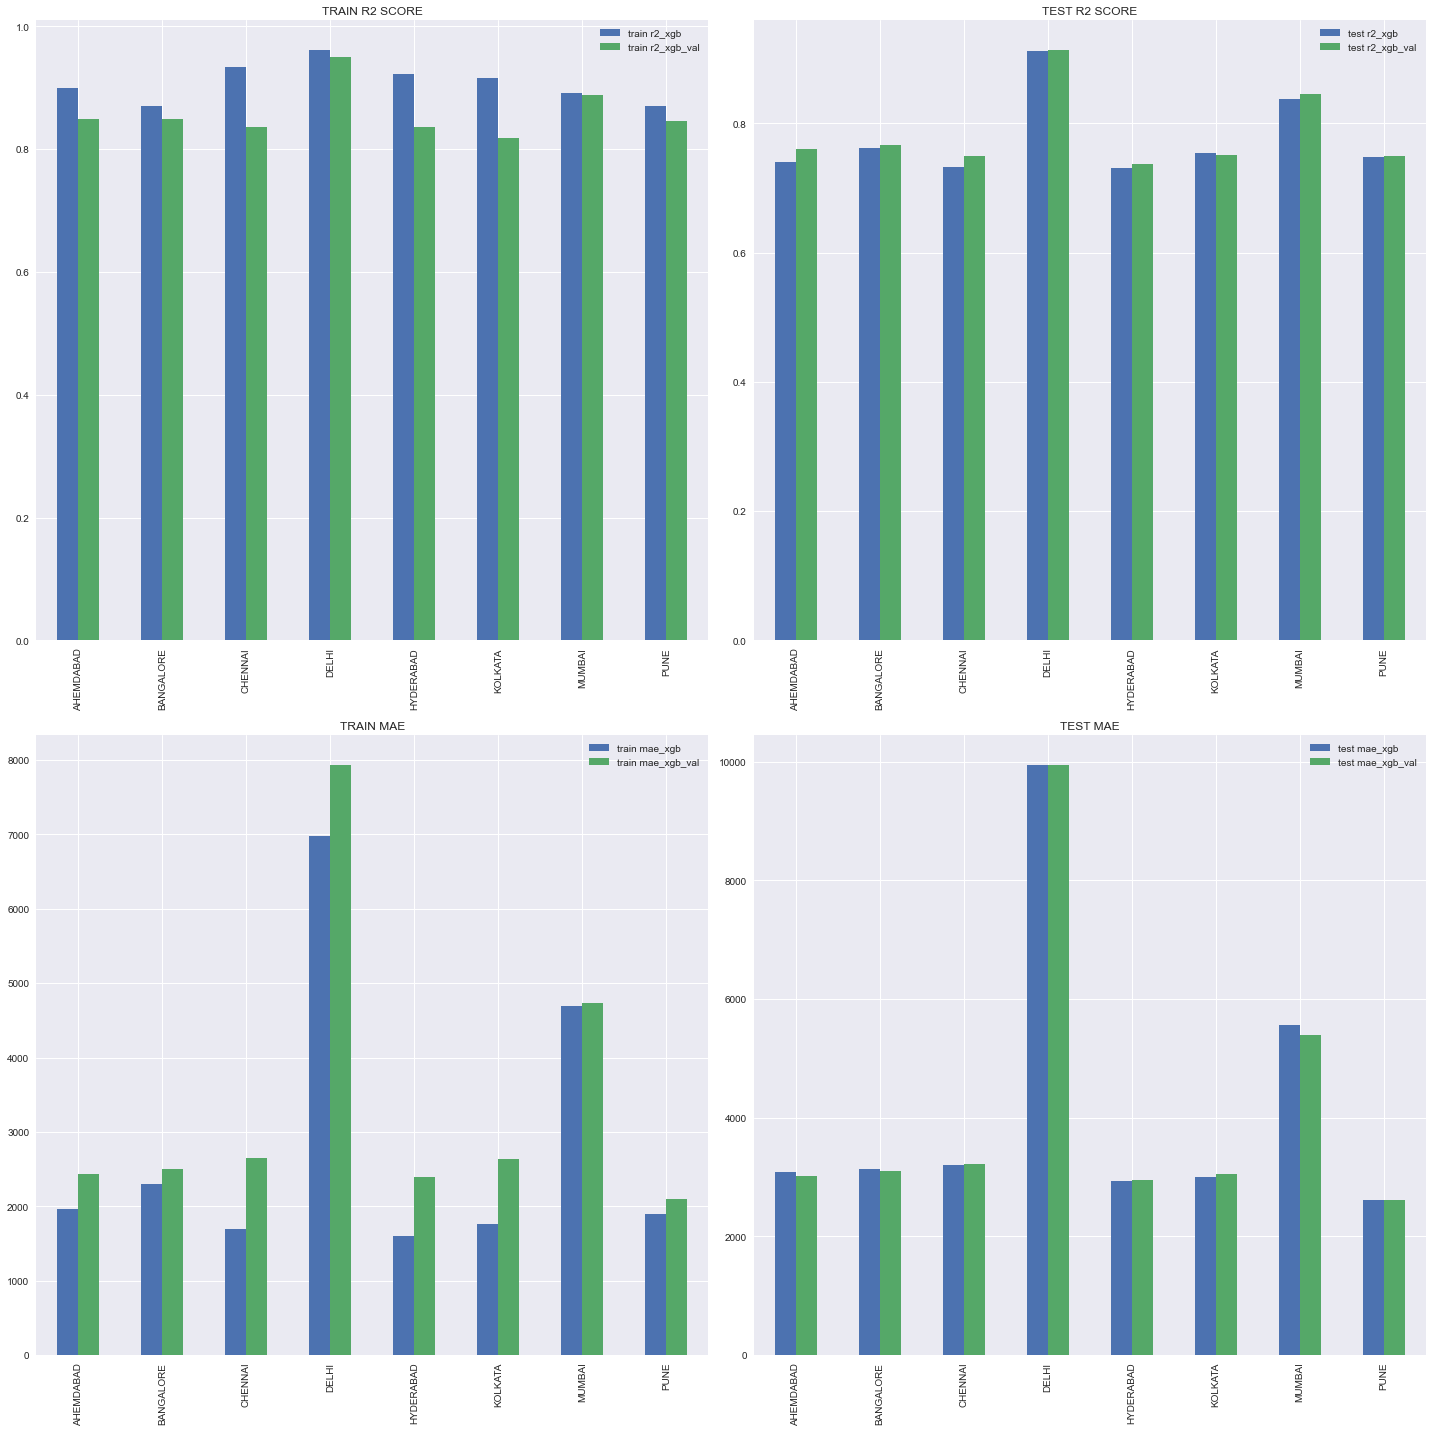

In [29]:
fig, ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2) #create a 2*2 figure 
final_metrics_df[['train r2_xgb', 'train r2_xgb_val']].plot(kind='bar',ax=ax[0,0],title='TRAIN R2 SCORE') #plot train r2 for both models 
final_metrics_df[['test r2_xgb', 'test r2_xgb_val']].plot(kind='bar',ax=ax[0,1], title='TEST R2 SCORE') #plot test r2 for both models 
final_metrics_df[['train mae_xgb', 'train mae_xgb_val']].plot(kind='bar', ax=ax[1,0], title='TRAIN MAE') #plot train mae for both models 
final_metrics_df[['test mae_xgb', 'test mae_xgb_val']].plot(kind='bar', ax=ax[1,1],title='TEST MAE') #plot test mae for both models 
plt.tight_layout() #tight layout to avoid overlap 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'hyperparameter_tuning.png')) #save the figure 
plt.show() #show the figure 

Since train and test mae for xgb_validated is higher than xgb for most cities, hence we save xgb model instead of xgb_val

In [30]:
# save the models after fitting them on entire dataset 
for city in CITIES:
    if not os.path.exists(MODEL_SAVE_PATH):
        os.makedirs(MODEL_SAVE_PATH)
    xgb_model = XGBRegressor(objective='reg:squarederror')
    xgb_model.fit(X_dict[city], y_dict[city])
    joblib.dump(xgb_model, os.path.join(MODEL_SAVE_PATH, f'{city}_model.pkl'))